# Import

In [4]:
# 기본 세팅
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import gaussian_kde
from matplotlib import colors as mpl_colors
import os
import argparse
from datetime import datetime
from glob import glob
from itertools import product, groupby
from mpl_toolkits.mplot3d import Axes3D
import re

# Font & Color

##### TODO
- font download

In [20]:
# font = {'family': 'Tahoma'}
# font = {'family': 'Times New Roman'}

# plt.rc('font', **font)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
colors_fill = [None, "#54637C", "#587C86", "#5D928B","#65A68D", 
               "#71B88E", "#83C98F", "#9CD790", "#BBE394", 
               "#D9ED9D", "#F1F4B0", "#FEFAD3"]
grid_color = 'gainsboro'

In [6]:
def layerNum(model:str) -> int:
    if model == "densenet201" :
        return 306
    elif model == "resnet152" :
        return 206
    elif model == "enetb0" :
        return 136
    elif model == "csmobilenet-v2" :
        return 81
    elif model == "squeezenet" :
        return 50
    elif model == "yolov7" :
        return 143
    elif model == "yolov7-tiny" :
        return 99
    elif model == "yolov4" :
        return 162
    elif model == "yolov4-tiny" :
        return 38
    elif model == "resnet10" :
        return 17
    elif model == "yolov2-tiny" :
        return 16
    else :
        print("Unknown model: ", model)
        return 0

def maxCore(device:str) -> int:
    if device == "nano":
        return 4
    if device == "orin":
        return 10
    else:
        print("Unknown device: ", device)
        return 0

### Options

In [7]:
save_formats = ['png', 'pdf', 'svg']
devices = ['nano', 'orin']
types = ["toy_simul", "real_simul", "real_exp"]
models = ['densenet201', 'resnet152', 'enetb0', 'csmobilenet-v2', 'squeezenet', 'yolov7', 'yolov7-tiny', 'yolov4', 'yolov4-tiny', 'resnet10', 'yolov2-tiny']

device = 'nano'
type = "real_exp"
model = "densenet201"
date_label = "0106"

max_cores = maxCore(device)
if type not in types:
    print("Unknown type: ", type)
layer_num = layerNum(model)
if not os.path.exists(f"../../csv/{date_label}"):
    print(f"Invalid date: {date_label}")

In [8]:
for save_format in save_formats:
    directory_path = f'./{save_format}'
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"디렉터리 '{directory_path}' 생성 완료!")
    else:
        print(f"디렉터리 '{directory_path}'가 이미 존재합니다.")

디렉터리 './png' 생성 완료!
디렉터리 './pdf' 생성 완료!
디렉터리 './svg' 생성 완료!


### Load csv & Dataframe 생성

In [16]:
base_path = f"../../csv/{date_label}/gpu_accel_0_M/{model}/"

# 데이터를 수집할 데이터프레임을 초기화
columns = ['glayer', 'throughput', 'frame_rate', 'execution_time', 'cycle_time', 
           'num_thread_data', 'num_thread', 'accel_gain', 'block_loss', 'max_delay', 'min_delay']
data_list = []

num_thread = max_cores
path = os.path.join(base_path, f"{num_thread}thread")
for filename in sorted(os.listdir(path)):
    if filename.endswith(".csv"):
            num_glayer = int(filename.split('_')[2].replace('.csv', ''))
            df = pd.read_csv(os.path.join(path, filename))
            task_num = len(df)
            start_preprocess_time = df["start_preprocess"].iloc[0]
            end_infer_time = df["end_postprocess"].iloc[-1]
            Throughput = task_num / (end_infer_time - start_preprocess_time) * 1000
            if(num_glayer == 0):
                infer_time_standard = df["e_infer"].mean() - df["waiting_gpu"].mean()
            acceleration_gain = infer_time_standard - (df["e_infer"].mean() - df["waiting_gpu"].mean())

            block_loss = df["waiting_gpu"].mean()
            max_delay = df["execution_time"].max()
            min_delay = df["execution_time"].min()
            avg_frame_rate = df["frame_rate"].mean()
            avg_execution_time = df["execution_time"].mean()
            avg_cycle_time = df["cycle_time"].mean()
            avg_num_thread_data = df["num_thread"].mean()
            
            # 데이터프레임에 데이터 추가
            data_list.append([num_glayer, Throughput, avg_frame_rate, avg_execution_time, 
                              avg_cycle_time, avg_num_thread_data, num_thread, acceleration_gain, 
                              block_loss, max_delay, min_delay])
# 데이터프레임 생성
data_df = pd.DataFrame(data_list, columns=columns)
data_df = data_df.pivot(index='glayer', columns='num_thread')

frame_rate_df = data_df['frame_rate']
execution_time_df = data_df['execution_time']
cycle_time_df = data_df['cycle_time']

# 파일 경로 설정
# frame_rate_file_path = './gpu-accel-GC_frame_rate_data.csv'
# execution_time_file_path = './gpu-accel-GC_execution_time_data.csv'
# cycle_time_file_path = './gpu-accel-GC_cycle_time_data.csv'

# # 파일 저장
# frame_rate_df.to_csv(frame_rate_file_path)
# execution_time_df.to_csv(execution_time_file_path)
# cycle_time_df.to_csv(cycle_time_file_path)

# print(frame_rate_file_path, execution_time_file_path, cycle_time_file_path)

### Max throughput 계산

In [17]:

# # 결과를 저장할 리스트 초기화
# max_values = []

# # 각 스레드 수에 대해 반복
# for num_thread in range(1, num_total_cores):
#     if num_thread in data_df['frame_rate'].columns:
#         # frame_rate의 최대값 찾기
#         max_throughput = data_df['throughput'][num_thread].max()
#         # 최대 frame_rate의 인덱스 찾기
#         max_index = data_df['throughput'][num_thread].idxmax()
#         # 해당 인덱스의 execution_time 가져오기
#         corresponding_execution_time = data_df['execution_time'][num_thread].loc[max_index]

#         # 결과 저장
#         max_values.append({
#             'num_thread': num_thread,
#             'glayer': max_index,
#             'max_throughput': max_throughput,
#             'execution_time_at_max_fr': corresponding_execution_time
#         })

# # 결과 출력
# print("Point for Max Frame rate")
# for result in max_values:
#     print(f"Threads: {result['num_thread']}, Glayers: {result['glayer']}, 
#           Max Throughput: {result['max_throughput']:.2f}, 
#           Execution Time: {result['execution_time_at_max_fr']:.2f}")

### 다음 thread의 throughput 넘는 지점 찾기

In [19]:
# # 결과를 저장할 리스트 초기화
# cross_points = []

# # 각 스레드 수와 그 다음 스레드 수 비교
# for num_thread in range(10, num_total_cores - 1):
#     current_thread_frame_rates = data_df['frame_rate'][num_thread]
#     next_thread_frame_rates = data_df['frame_rate'][num_thread + 1]
#     current_thread_execution_time = data_df['execution_time'][num_thread]
#     next_thread_execution_time = data_df['execution_time'][num_thread + 1]
    
#     # glayer를 순회하면서 현재 스레드의 frame_rate가 다음 스레드의 frame_rate를 넘는 첫 번째 지점 찾기
#     for glayer in current_thread_frame_rates.index:
#         if current_thread_frame_rates[glayer] >= next_thread_frame_rates[glayer]:
#             cross_points.append({
#                 'num_thread': num_thread,
#                 'glayer': glayer,
#                 'current_frame_rate': current_thread_frame_rates[glayer],
#                 'next_frame_rate': next_thread_frame_rates[glayer],
#                 'current_execution_time': current_thread_execution_time[glayer],
#                 'next_execution_time': next_thread_execution_time[glayer]
#             })
#             break  # 첫 번째 조건 충족 지점에서 루프 종료

# # 결과 출력
# for point in cross_points:
#     print(f"Thread {point['num_thread']} exceeds Thread {point['num_thread']+1} 
#           at Glayer {point['glayer']}:")
#     print(f"  Thread {point['num_thread']}: {point['current_frame_rate']:.2f} fps, 
#           Thread {point['num_thread']+1}: {point['next_frame_rate']:.2f} fps")
#     print(f"  Thread {point['num_thread']}: {point['current_execution_time']:.2f} ms, 
#           Thread {point['num_thread']+1}: {point['next_execution_time']:.2f} ms")

### throughput & delay

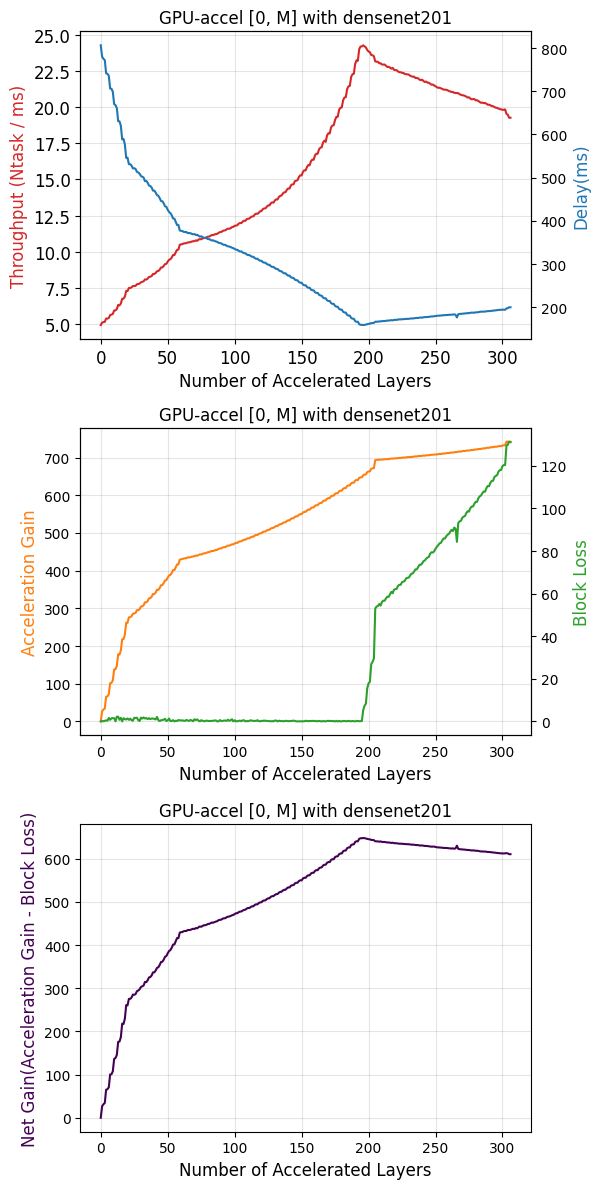

In [30]:
# Set up the plot
fig, (ax1, ax3, ax5) = plt.subplots(3, 1, figsize=(6, 12))
ax2 = ax1.twinx()
ax4 = ax3.twinx()
colors = plt.cm.viridis(np.linspace(0, 1, 4))  # max_total_cores개의 색상을 viridis 컬러맵에서 선택
# 각 스레드에 대한 데이터 플롯
for num_thread in range(4, 5):
    color = colors[num_thread % len(colors)]
    color_fill = colors_fill[num_thread]
    if num_thread in data_df.columns.levels[1]:
        ax1.plot(data_df.index, data_df[('throughput', num_thread)], label=f"{num_thread} threads", color="tab:red", zorder = num_thread)
        ax2.plot(data_df.index, data_df[('execution_time', num_thread)], color="tab:blue", zorder = num_thread)
        ax3.plot(data_df.index, data_df[('accel_gain', num_thread)], color="tab:orange", zorder = num_thread)
        ax4.plot(data_df.index, data_df[('block_loss', num_thread)], color="tab:green", zorder = num_thread)
        ax5.plot(data_df.index, data_df[('accel_gain', num_thread)] - data_df[('block_loss', num_thread)], color=color, zorder = num_thread)
        # ax1.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)
        # ax3.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)
        # ax5.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)

        # if (num_thread == 1) or (num_thread == 2) or (num_thread == num_total_cores):
        #     ax2.plot(data_df.index, data_df[('num_thread_data', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index, data_df[('num_thread_data', num_thread)], color=color_fill, zorder=num_thread)
        # else:
        #     exceed_num = cross_points[num_thread - 3]['glayer']
        #     ax2.plot(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], color=color_fill, zorder=num_thread)

ax1.set_xlabel('Number of Accelerated Layers', size=12)
ax3.set_xlabel('Number of Accelerated Layers', size=12)
ax5.set_xlabel('Number of Accelerated Layers', size=12)

ax1.set_ylabel("Throughput (Ntask / ms)", size=12, color="tab:red")
ax2.set_ylabel("Delay(ms)", size = 12, color="tab:blue")
ax3.set_ylabel("Acceleration Gain", size=12, color="tab:orange")
ax4.set_ylabel("Block Loss", size = 12, color="tab:green")
ax5.set_ylabel("Net Gain(Acceleration Gain - Block Loss)", size = 12, color=color)

ax1.set_title(f"GPU-accel [0, M] with {model}", size=12)
ax3.set_title(f"GPU-accel [0, M] with {model}", size=12)
ax5.set_title(f"GPU-accel [0, M] with {model}", size=12)

ax1.tick_params(axis='both', labelsize=12)
plt.tight_layout()
ax1.grid(color='gray', alpha=0.2)
ax3.grid(color='gray', alpha=0.2)
ax5.grid(color='gray', alpha=0.2)
plt.show()


3. real_exp

In [12]:
device = 'nano'
type = "real_exp"
model = "densenet201"
date_label = "0106"

max_cores = maxCore(device)
if type not in types:
    print("Unknown type: ", type)
layer_num = layerNum(model)
if not os.path.exists(f"../../csv/{date_label}"):
    print(f"Invalid date: {date_label}")

In [13]:
# cpu_layer_time_path = f"../../csv/{date_label}/layer_time/{model}/cpu_raw_data_01blas.csv"
# gpu_layer_time_path = f"../../csv/{date_label}/layer_time/{model}/gpu_raw_data.csv"

In [14]:
# 파일 경로 설정
files = {
    'Seq\n(Full CPU)': f"../../csv/{date_label}/sequential/{model}/sequential_cpu_01core.csv",
    'TPA\n(Full CPU)': f"../../csv/{date_label}/pipeline/{model}/pipeline_cpu.csv",
    'DPA\n(Full CPU)': f"../../csv/{date_label}/data_parallel/{model}/data-parallel_cpu_4thread.csv",
    'Seq\n(Full GPU)': f"../../csv/{date_label}/sequential/{model}/sequential_gpu_01core.csv",
    'TPA\n(Full GPU)': f"../../csv/{date_label}/pipeline/{model}/pipeline_gpu.csv",
    'DPA\n(Full GPU)': f"../../csv/{date_label}/data_parallel/{model}/data-parallel_gpu_4thread.csv"
}

# 데이터 저장을 위한 딕셔너리
throughput = {}
average_execution_times = {}
block_losses = {}
accel_gains = {}
pre_components = {}
infer_components = {}
post_components = {}
block_components = {}

# 파일 별로 데이터 로드 및 평균 계산
for label, file_path in files.items():
    data = pd.read_csv(file_path)
    
    # frame_rate의 평균 계산
    task_num = len(data)
    start_preprocess_time = data["start_preprocess"].iloc[0]
    end_infer_time = data["end_postprocess"].iloc[-1]
    Throughput = task_num / (end_infer_time - start_preprocess_time) * 1000
    throughput[label] = Throughput
    # execution_time의 평균 계산
    average_execution_time = data['execution_time'].mean()
    average_execution_times[label] = average_execution_time
    if "waiting gpu" in data.columns:
        block_loss = data["waiting gpu"].mean()
        block_losses[label] = block_loss
    elif "e_stall" in data.columns:
        block_loss = data["e_stall"].mean()
        block_losses[label] = block_loss
    else:
        block_losses[label] = 0

    pre_component = data["e_preprocess"].mean()
    pre_components[label] = pre_component
    infer_component = data["e_infer"].mean()
    infer_components[label] = infer_component
    post_component = data["e_postprocess"].mean()
    post_components[label] = post_component
    block_components[label] = block_losses[label]

    if(label == "Seq\n(Full GPU)"):
        accel_gain = pre_components["Seq\n(Full CPU)"] - pre_components[label] + infer_components["Seq\n(Full CPU)"] - infer_components[label] + post_components["Seq\n(Full CPU)"] - post_components[label]
        # accel_gain = average_execution_times["Seq\n(Full CPU)"] - average_execution_times[label]
        accel_gains[label] = accel_gain
    elif(label == "TPA\n(Full GPU)"):
        accel_gain = pre_components["TPA\n(Full CPU)"] - pre_components[label] + infer_components["TPA\n(Full CPU)"] - infer_components[label] + post_components["TPA\n(Full CPU)"] - post_components[label]
        # accel_gain = average_execution_times["TPA\n(Full CPU)"] - average_execution_times[label]  
        accel_gains[label] = accel_gain
    elif(label == "DPA\n(Full GPU)"):
        accel_gain = pre_components["DPA\n(Full CPU)"] - pre_components[label] + infer_components["DPA\n(Full CPU)"] - infer_components[label] + post_components["DPA\n(Full CPU)"] - post_components[label]
        # accel_gain = average_execution_times["DPA\n(Full CPU)"] - average_execution_times[label]
        accel_gains[label] = accel_gain  

# Graph

##### 1. Average Frame Rate

In [36]:
print(f'./{save_format}/Throughput-{device}-{type}-{model}-{date_label}.{save_format}')

./svg/Throughput-nano-toy_simul-GPU >>> CPU-0106.svg


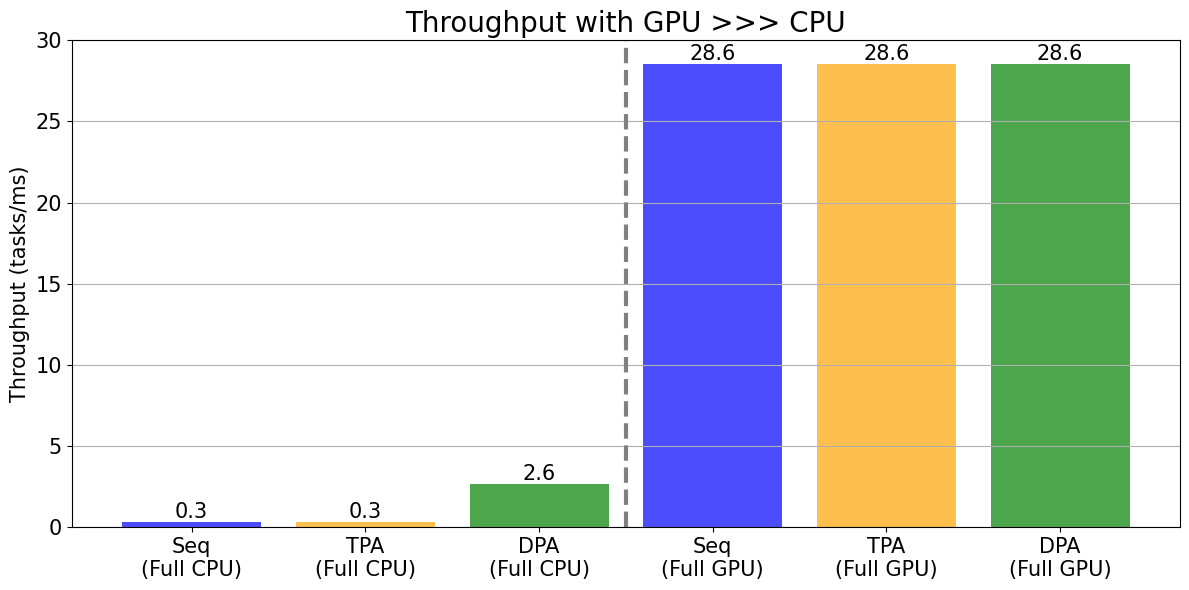

In [31]:
fig = plt.figure(figsize=(12, 6))

# 첫 번째 그래프: Average Frame Rate
bars1 = plt.bar(throughput.keys(), throughput.values(), color=colors[:3], alpha=0.7)
plt.ylabel('Throughput (tasks/ms)', size = 15)
plt.title(f'Throughput with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=3)  # x=2.5 위치에 점선 추가

# 막대 위에 텍스트 추가
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{save_format}/Throughput-{device}-{type}-{model}-{date_label}.{save_format}')

##### 2. Average Execution Time

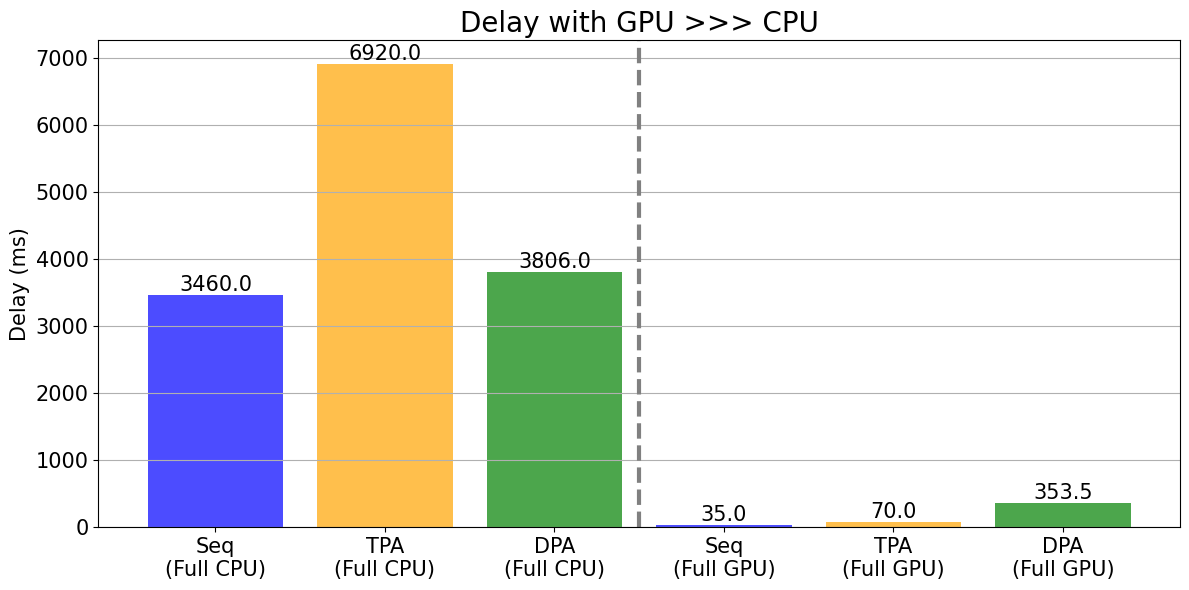

In [32]:
fig = plt.figure(figsize=(12, 6))

# 두 번째 그래프: Average Execution Time
bars2 = plt.bar(average_execution_times.keys(), average_execution_times.values(), color=colors[:3], alpha=0.7)
plt.ylabel('Delay (ms)', size = 15)
plt.title(f'Delay with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=3)  # x=2.5 위치에 점선 추가

# 막대 위에 텍스트 추가
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{save_format}/Delay-{device}-{type}-{model}-{date_label}.{save_format}')

##### 3. Block Loss / Pipeline stall

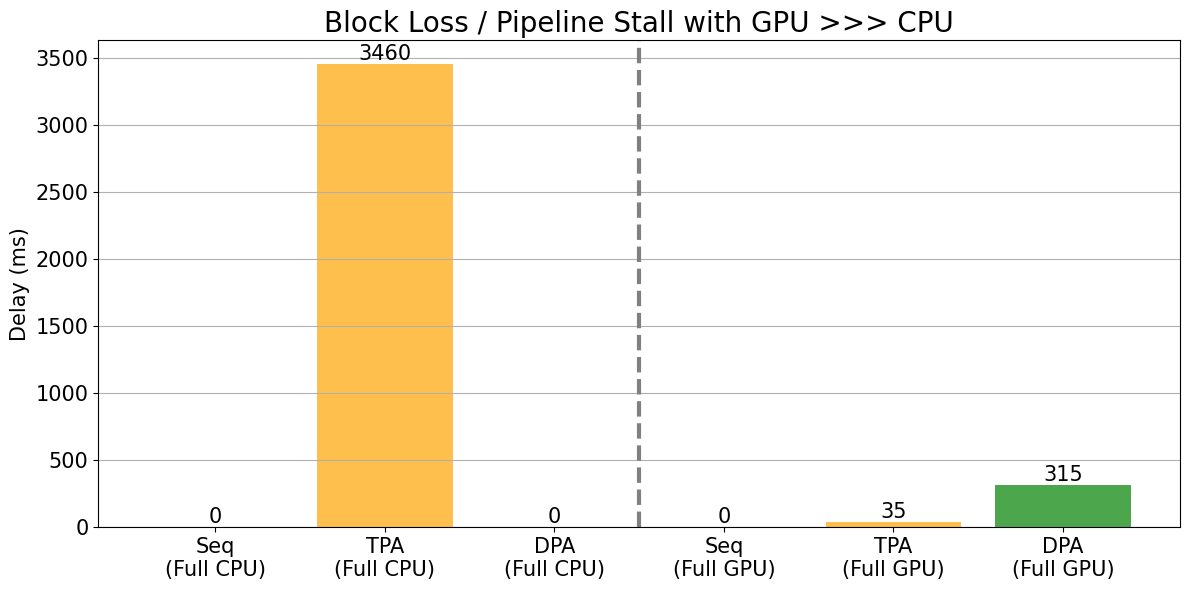

In [33]:
fig = plt.figure(figsize=(12, 6))

# tp 번째 그래프: Block Loss
bars3 = plt.bar(block_losses.keys(), block_losses.values(), color=colors[:3], alpha=0.7)
plt.ylabel('Delay (ms)', size = 15)
plt.title(f'Block Loss / Pipeline Stall with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=3)  # x=2.5 위치에 점선 추가

# 막대 위에 텍스트 추가
for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{save_format}/BlockLoss-{device}-{type}-{model}-{date_label}.{save_format}')

##### 4. Acceleration Gain

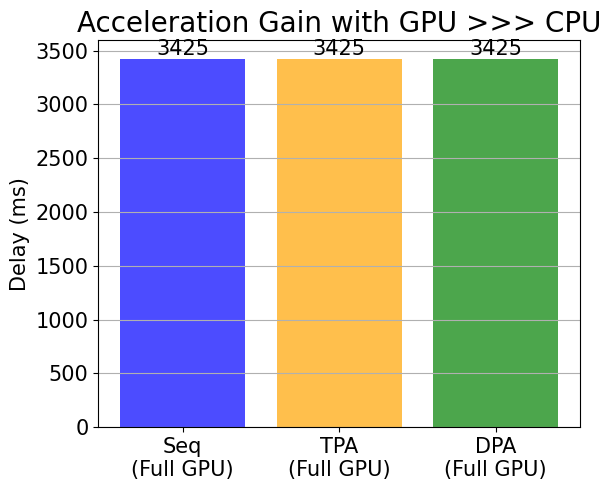

In [34]:
fig = plt.figure(figsize=(6, 5))

# 네 번째 그래프: Acceleration Gain
bars4 = plt.bar(accel_gains.keys(), accel_gains.values(), color=colors, alpha=0.7)
plt.ylabel('Delay (ms)', size = 15)
plt.title(f'Acceleration Gain with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.tick_params(labelsize=15)

# 막대 위에 텍스트 추가
for bar in bars4:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{save_format}/Acceleration_gain-{device}-{type}-{model}-{date_label}.{save_format}')

##### 5. Delay Component

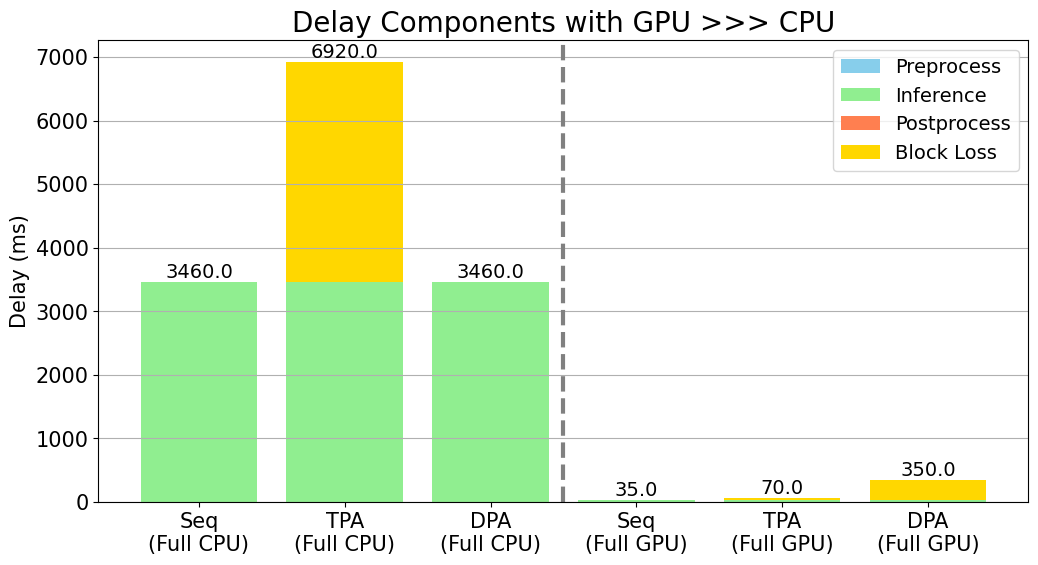

In [35]:
plt.figure(figsize=(12, 6))
x_labels = list(pre_components.keys())
pre_values = np.array(list(pre_components.values()))
infer_values = np.array(list(infer_components.values()))
post_values = np.array(list(post_components.values()))
block_values = np.array(list(block_components.values()))

# 첫 번째 그래프: Delay Components
bar1 = plt.bar(x_labels, pre_values, color='skyblue', label='Preprocess')
bar2 = plt.bar(x_labels, infer_values, color='lightgreen',bottom=np.array(pre_values), label='Inference')
bar3 = plt.bar(x_labels, post_values, bottom=np.array(pre_values) + np.array(infer_values), color='coral', label='Postprocess')
bar4 = plt.bar(x_labels, block_values,
               bottom=np.array(pre_values) + np.array(infer_values) + np.array(post_values),
               color='gold', label='Block Loss')

# 막대 위에 텍스트 추가
for i in range(6):
    total_height = (pre_values[i] + infer_values[i] +
                    post_values[i] + block_values[i])
    plt.text(i, total_height, f'{total_height:.1f}', ha='center', va='bottom', fontsize=14)

plt.legend(fontsize=14)
plt.ylabel('Delay (ms)', size = 15)
plt.title(f'Delay Components with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=3)  # x=2.5 위치에 점선 추가
plt.tick_params(labelsize=15)